## Notebook to compare predictions for anze's glass interpolator vs our GP emulator

Start by loading the glass class

In [59]:
import numpy as np
import matplotlib as pyplot
import p1d_arxiv
import gp_emulator
import os
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.spatial as spat

In [79]:
class GlassInterpolator:
    def __init__ (self, x, y, metric=None):
        self.x = x
        self.y = y
        self.L=x.shape[0]
        self.N=x.shape[1]
        
        if metric is None:
            self.metric=np.ones(self.N)
            self.xn=np.copy(self.x)
        else:
            self.metric=metric
            self._getxn()
        self.delunay = None
        
    def _getxn(self):
        self.xn=np.copy(self.x)
        for i,v in enumerate(self.metric):
            self.xn[:,i]/=v

            
    def _interpolate(self,atxn,ndx, quadratic=False):
        x0=self.xn[ndx[0]]
        y0=self.y[ndx[0]]
        ndx=ndx[1:]
        ofs = np.array([self.xn[i]-x0 for i in ndx])
        yofs = np.array([self.y[i]-y0 for i in ndx])
        dx0=atxn-x0
        if quadratic:
            extra=np.array([ofs[:,i]*ofs[:,j] for i in range(self.N) for j in range(i, self.N)]).T
            ofs=np.hstack((ofs,extra))
            dx0=np.hstack((dx0, np.array([dx0[i]*dx0[j] for i in range(self.N) for j in range(i, self.N)])))
        if ofs.shape[0]==ofs.shape[1]:
            result=y0+np.einsum('ij,jk,i->k', la.inv(ofs), yofs,dx0)
        else:
            result=y0+np.einsum('ij,jk,i->k', la.pinv(ofs), yofs,dx0)
        return result

    def __call__(self,atx,kind='L'):
        ## first get closest neighbors
        atxn=np.copy(atx)/self.metric
        ## kind can be N for nearest, L for linear, Q for quadratic, D for Delaunay, P for Pseudoinverse
        assert (kind in 'NLQDP')
        if kind in ['N','L','Q']:
            di=((self.xn-np.outer(np.ones(self.L),atxn))**2).sum(axis=1)
            ndx=np.argsort(di)
            ## now let's see how many we need in addition to the first one
            if kind=='N':
                result=self.y[ndx[0]]
            else:
                quadratic = kind=='Q'
                M=1+self.N + int(quadratic) * self.N*(self.N+1)//2
                result=self._interpolate(atxn,ndx[:M],quadratic)
        elif kind=='D' or kind=='P':
            if self.delunay is None:
                self.delunay = spat.Delaunay(self.xn)
            s=self.delunay.find_simplex(atxn)
            ndx=self.delunay.simplices[s]
            if kind=='D':
                result=self._interpolate(atxn,ndx)
            elif kind=='P':
                ## let's add twice more indices 
                di=((self.xn-np.outer(np.ones(self.L),atxn))**2).sum(axis=1)
                ndxmore=np.argsort(di)[:self.N+1]
                closest=ndxmore[0]               
                ndx=np.array([closest]+list(set(ndx)|set(ndxmore)-set([closest])))                
                result=self._interpolate(atxn,np.array(ndx))
                        
        return result

In [34]:
simnum=63

repo=os.environ['LYA_EMU_REPO']
skewers_label='Ns256_wM0.05'
#skewers_label=None
basedir=repo+"/p1d_emulator/sim_suites/emulator_256_28082019/"
#basedir=repo+"/p1d_emulator/sim_suites/emulator_256_15072019/"
p1d_label=None
undersample_z=1
paramList=["mF","sigT_Mpc","gamma","n_p","Delta2_p"]
max_arxiv_size=None
kmax_Mpc=8
z_list=None

In [35]:
archive=p1d_arxiv.ArxivP1D(basedir=basedir,nsamples=199,
                            drop_tau_rescalings=True,z_max=4,drop_sim_number=simnum,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

truth=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,pick_sim_number=simnum,
                            drop_temp_rescalings=True,skewers_label=skewers_label)
## Set up k bins for emulator call
k_test=truth.data[1]["k_Mpc"][1:]
k_test=k_test[k_test<8]

emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",z_list=z_list,passArxiv=archive,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 1584 points
Optimised


In [36]:
glass_x,glass_y=emu._buildTrainingSets(archive,paramList)

In [80]:
V=GlassInterpolator(glass_x,glass_y)

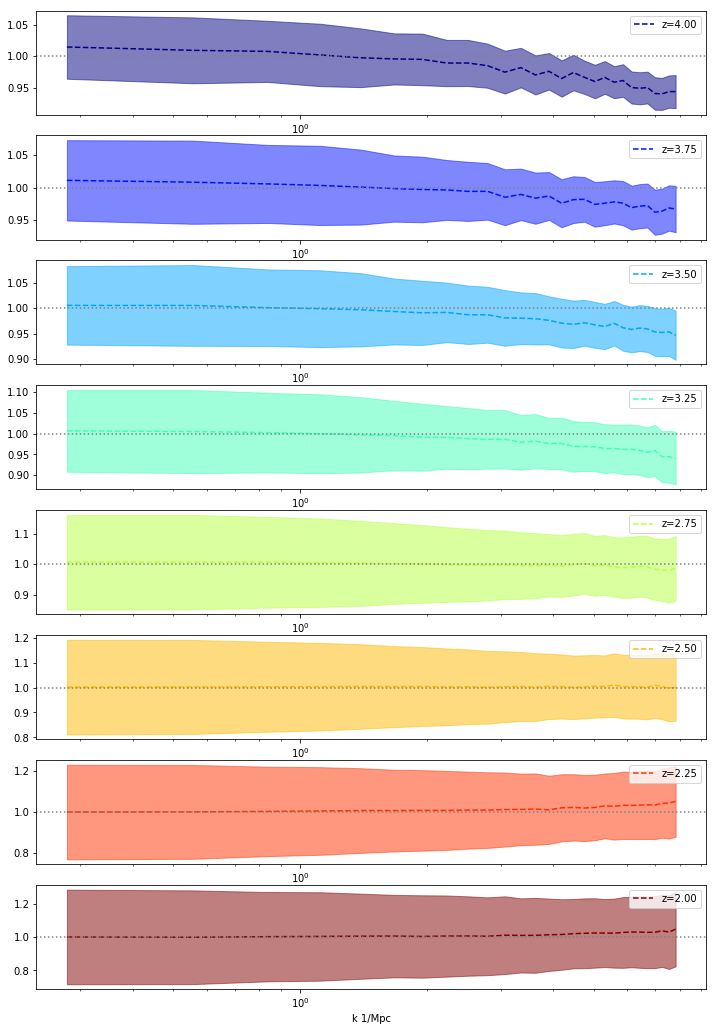

In [53]:
plt.figure(figsize=[12,18])
plt.title("Predicted/truth, single GP emulator")
dex=0
for aa,item in enumerate(truth.data):
    plt.subplot(len(truth.data),1,aa+1)
    #plt.subplot(2,1,1)
    #print(dex/(len(truth.data)-1))
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    glass_call=[]
    for param in paramList:
        emu_call[param]=item[param]
        glass_call.append(item[param])
    pred,err=emu.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_glass=V(glass_call,quadratic=True)
    ## Plot z with different limits
    plt.plot(k_test,pred/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="dashed",label="z=%.2f" % item["z"])
    plt.fill_between(k_test,(pred+np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred-np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)
    plt.axhline(1,linestyle=":",color="gray")
    plt.xscale("log")
    plt.legend()
    #plt.plot(k_test,item["p1d_Mpc"][1:(len(k_test)+1)],marker="o",color=col,linestyle="None")
    #plt.plot(k_test,pred_glass[1:len(k_test)+1],color=col,linestyle="None",marker="x")
    
    #plt.subplot(2,1,2)
    
    ## Print diffs
    #print(pred_z_samepar-pred_z)
    #print("Error diff")
    #print(np.sqrt(np.diag(err_z_samepar))-np.sqrt(np.diag(err_z)))

#plt.xscale("log")
plt.xlabel("k 1/Mpc")
plt.savefig("single_GP_emulator.pdf")

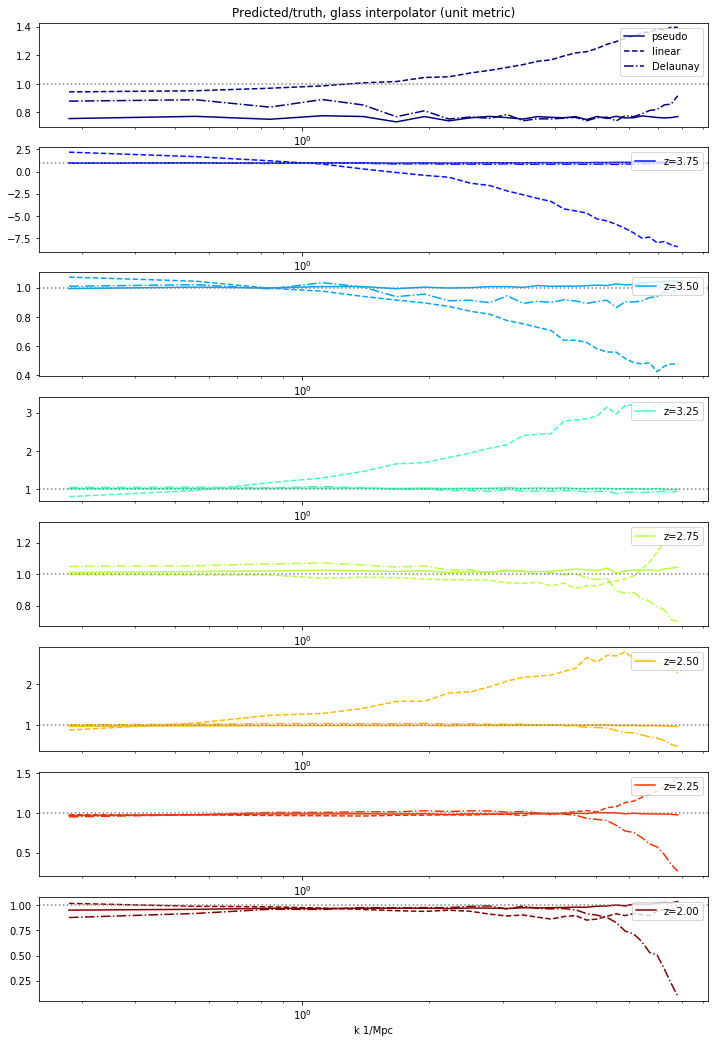

In [82]:
plt.figure(figsize=[12,18])
plt.title("Predicted/truth, glass interpolator (unit metric)")
dex=0
for aa,item in enumerate(truth.data):
    plt.subplot(len(truth.data),1,aa+1)
    #plt.subplot(2,1,1)
    #print(dex/(len(truth.data)-1))
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    glass_call=[]
    for param in paramList:
        emu_call[param]=item[param]
        glass_call.append(item[param])
    pred_glass_pseud=V(glass_call,kind="P")
    pred_glass_lin=V(glass_call,kind="L")
    #pred_glass_quad=V(glass_call,kind="Q")
    pred_glass_del=V(glass_call,kind="D")
    if aa==0:
        plt.title("Predicted/truth, glass interpolator (unit metric)")
        plt.plot(k_test,pred_glass_psued[1:len(k_test)+1]/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="solid",label="pseudo")
        plt.plot(k_test,pred_glass_lin[1:len(k_test)+1]/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="dashed",label="linear")
        #plt.plot(k_test,pred_glass_quad[1:len(k_test)+1]/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle=":",label="quad")
        plt.plot(k_test,pred_glass_del[1:len(k_test)+1]/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="-.",label="Delaunay")
        plt.axhline(1,linestyle=":",color="gray")
        plt.xscale("log")
        plt.legend(loc="upper right")
    else:
        plt.plot(k_test,pred_glass_pseud[1:len(k_test)+1]/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="solid",label="z=%.2f" % item["z"])
        plt.plot(k_test,pred_glass_lin[1:len(k_test)+1]/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="dashed")
        #plt.plot(k_test,pred_glass_quad[1:len(k_test)+1]/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle=":")
        plt.plot(k_test,pred_glass_del[1:len(k_test)+1]/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="-.")
        plt.axhline(1,linestyle=":",color="gray")
        plt.xscale("log")
        plt.legend(loc="upper right")

plt.xlabel("k 1/Mpc")
plt.savefig("glass_interpolator_unit_metric.pdf")

In [86]:
## Now try the glass prediction rescaling params to unit volume - can use training_x_grid and paramLimits functions
## from the emulator to do this

V_unit=GlassInterpolator(emu.X_param_grid,glass_y)

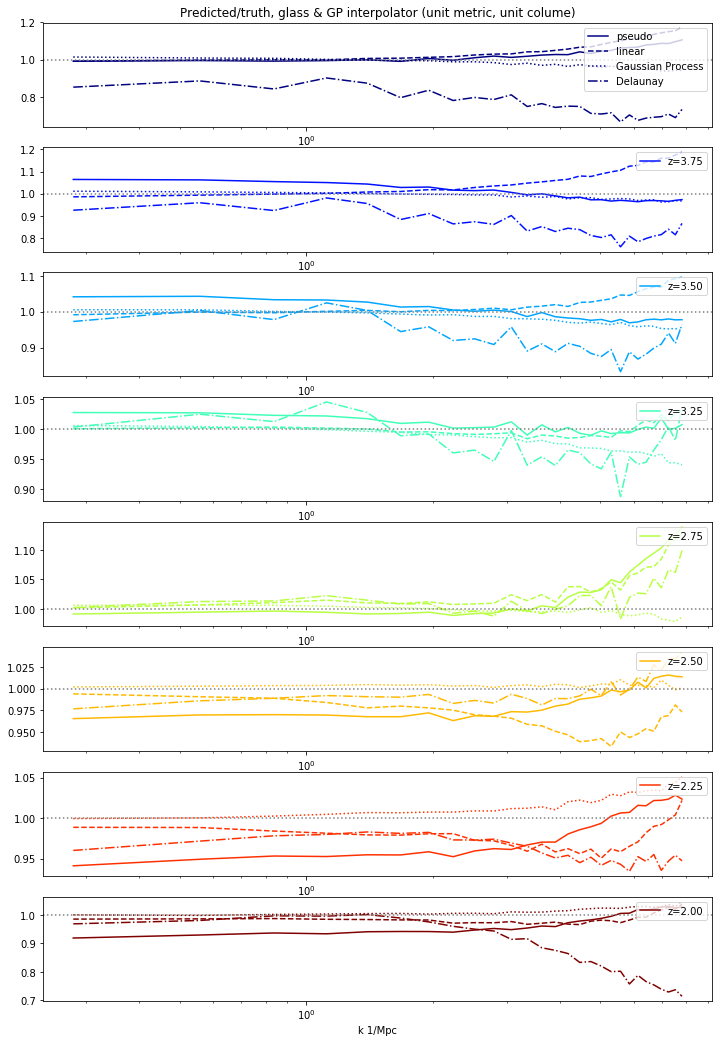

In [89]:
plt.figure(figsize=[12,18])
plt.title("Predicted/truth, glass interpolator (unit metric)")
dex=0
for aa,item in enumerate(truth.data):
    plt.subplot(len(truth.data),1,aa+1)
    #plt.subplot(2,1,1)
    #print(dex/(len(truth.data)-1))
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    glass_call=[]
    emu_call={}
    for bb,param in enumerate(paramList):
        glass_call.append(item[param])
        glass_call[-1]=(glass_call[-1]-emu.paramLimits[bb,0])/(emu.paramLimits[bb,1]-emu.paramLimits[bb,0])
        emu_call[param]=item[param]
    pred_glass_pseud=V_unit(glass_call,kind="P")
    pred_glass_lin=V_unit(glass_call,kind="L")
    #pred_glass_quad=V_unit(glass_call,kind="Q")
    pred_glass_del=V_unit(glass_call,kind="D")
    pred,err=emu.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    if aa==0:
        plt.title("Predicted/truth, glass & GP interpolator (unit metric, unit colume)")
        plt.plot(k_test,pred_glass_pseud[1:len(k_test)+1]/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="solid",label="pseudo")
        plt.plot(k_test,pred_glass_lin[1:len(k_test)+1]/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="dashed",label="linear")
        plt.plot(k_test,pred/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle=":",label="Gaussian Process")
        plt.plot(k_test,pred_glass_del[1:len(k_test)+1]/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="-.",label="Delaunay")
        plt.axhline(1,linestyle=":",color="gray")
        plt.xscale("log")
        plt.legend(loc="upper right")
    else:
        plt.plot(k_test,pred_glass_pseud[1:len(k_test)+1]/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="solid",label="z=%.2f" % item["z"])
        plt.plot(k_test,pred_glass_lin[1:len(k_test)+1]/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="dashed")
        plt.plot(k_test,pred/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle=":")
        plt.plot(k_test,pred_glass_del[1:len(k_test)+1]/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="-.")
        plt.axhline(1,linestyle=":",color="gray")
        plt.xscale("log")
        plt.legend(loc="upper right")

plt.xlabel("k 1/Mpc")
plt.savefig("glass_interpolator_unit_metric_unit_volume.pdf")